# Occupancy Grid SLAM

Simultaneous Localization And Mapping (SLAM) ist ein klassisches Problem der Robotik. 

Es gibt Szenarien, in denen Roboter autonom agieren sollen. Dafür ist die Kenntnis der Umgebung und des eigenen Standorts unabdingbar. Eine genaue Karte ist jedoch selten vorhanden, oft ist die Umgebung gar nicht oder nur teilweise bekannt. Ebenso häuﬁg ist die Genauigkeit der Positionsbestimmung unzureichend. Die Lösung ist, dass der Roboter eine eigene Karte erstellt und sich anhand dieser Karte in der Umgebung verortet. Ein großes Forschungsfeld ist beispielsweise seit einigen Jahren der motorisierte Individualverkehr. Mit SLAM werden zwei Aufgaben gelöst:

1. Positionsbestimmung in der Umgebung 
2. Erstellung einer Karte der Umgebung

Charakteristisch ist, dass für die Positionsbestimmung eine Karte und für die Erstellung der Karte eine Position benötigt wird. Da Beides anfangs nicht zur Verfügung steht, wird SLAM oft als Henne-oder-Ei-Problem bezeichnet 

Das grundsätzliche Vorgehen von SLAM ist, dass der Roboter die Umgebung beobachtet und kartiert. Anschließend bewegt er sich und beobachtet die Umgebung erneut und vergleicht die Beobachtung mit der Karte. Anhand dieses Vergleichs kann die Position bestimmt und die Karte inkrementell aufgebaut werden. Ziel des SLAMs es explizit nicht, sicherheitsrelevante Hinderniserkennung durchzuführen, sondern eine möglichst genaue Positionierung zu erreichen und eine anschaulichen Abbildung der Umgebung zu erstellen. Für die Positionsbestimmung existiert eine Vielzahl von verschiedenen Ortungssensoren und Verfahren. Diese sind jedoch teuer, oft nicht verfügbar und teilweise unzuverlässig. Daher ist das Ziel, diese Sensorik mit SLAM zu ergänzen oder sogar zu ersetzen. 

Um das SLAM Verfahren verständlich zu erklären wird zunächst auf die Erstellung einer Karte bei bekannten Positionen eingegangen, anschließend wird die Position des Fahrzeugs anhand einer vorhanden Karte und einer Punktwolke des Laserscanners bestimmt und schließlich beide Teile zum SLAM zusammengesetzt.

## Verwendete Daten

In diesem Notebook werden Daten der [KITTI Vision Benchmark Suite](http://www.cvlibs.net/) verwendet. Im Notebook *Export von KITTI Rohdaten* ist erklärt, wie diese heruntergeladen und exportiert werden. Wenn die dort verwendete Datenstruktur eingehalten wird, ist es möglich andere Daten zu verwenden.

<img src="fig/AnnieWay.jpg" alt="KITTI Fahrzeug AnnieWay" style="width: 350px;"/>

Es wird benötigt:

1. Eine Textdatei mit der initialen Startposition: x,y,yaw 
2. Jede Beobachtung als Punktwolke (x,y,z) im NumPy Binärformat gespeichert
3. Die Ground Truth Trajektorie für einen Vergleich als Textdatei: x,y,yaw

Die Daten, die im ersten Teil für die Erklärung benötigt werden sind im Pfad des Notebooks gespeichert.

## Parametrierung

Die Parametrierung in diesem Notebook ist so gewählt, dass die Ergebnisse anschaulich sind. Für die tatsächliche Parametrierung und weitere Filterung der Punktwolke bitte in die Studienarbeit beziehungsweise in den anderen Code schauen.


## Teil I: Erstellung der Karte - Mapping With Known Poses

### Beschreibung der Karte

Ein Occupancy Grid ist eine belegungsbasierte Karte. Die zweidimensionale Karte wird in eine Zellen aufgeteil. Jede dieser Zellen kann entweder *frei* oder *belegt* sein. Da die Position des Fahrzeugs eine Schätzung ist und die Beobachtungen der Umgebungen ebenfalls Unsicherheiten aufweisen wird der Zustand einer Zelle *m_i* als Wahrscheinlichkeit zwischen 0 und 1 angegeben. Innerhalb dieses Intervalls sind folgende Werte wichtig:

<img src="fig/pmi.png" alt="Belegung Karte" style="width: 400px;"/>

Anschaulich werden belegte Zellen schwarz dargestellt, freie weiß und wenn keine Information über den Zustand einer Zelle vorhanden ist, wird sie grau dargestellt.

### Ablauf

Ausgehend von einer unbekannten Umgebung, bei der zu keiner Zelle Belegungsinformationen werden die Beobachtungen iterativ hinzugefügt:

<img src="fig/Ablauf_Mapping.png" alt="Ablauf Mapping With Known Poses" style="width: 400px;"/>

Aus der Punktwolke einer Beobachtung im Fahrzeugkoordinatensystem wird zunächst ein horizontaler Querschnitt ausgeschnitten, der anschließend vom Koordinatensystem des Fahrzeugs anhand der als bekannt vorrausgesetzten Position des Fahrzeugs in das Kartenkoordinatensystem transformiert wird. Für jeden Punkt wird bestimmt, in welcher Zelle der Karte er liegt. Die Wahrscheinlichkeit, dass diese Zelle belegt ist, steigt. 

Alle Zellen, die sich zwischen dieser belegten Zellen und dem Laserscanner befinden, werden als frei bestimmt. Die Wahrscheinlichkeit, dass diese Zellen belegt sind, sinkt. 

Analog werden die folgenden Beobachtungen in die Karte integriert.

### 1. Filterung der Punktwolke

Die folgende Punktwolke enthällt eine gesamte Messung des Velodyne Laserscanners. Die Fahrbahnoberfläche, Hauswände, Personen und ein Fahrradfahrer, eine Straßenbahn und einige Schilder und Autos sind gut sichtbar. Beim Mapping wird nicht die komplette Punktwolke verarbeitet. Es wird lediglich ein horizontaler Querschnitt auf Höhe des Sensors (1.73m +- 0.05m) verwendet.

<img src="fig/pcl.png" alt="Gesamte Punktwolke" style="width: 600px;"/>

<IPython.core.display.Javascript object>


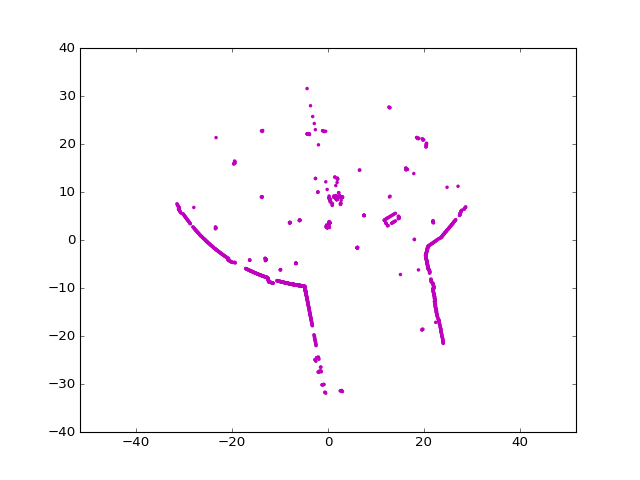

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

# load pointcloud 
pointcloud = np.load('data/pointcloud_0.npy')

# filter z-Values
zCutMin = -0.05
zCutMax = 0.05

binaryMask = np.logical_and( pointcloud[:,2]>zCutMin, pointcloud[:,2]<zCutMax)  
binaryMask = np.column_stack((binaryMask,binaryMask,binaryMask))
pointcloud = pointcloud[binaryMask]
pointcloud = np.reshape(pointcloud,(-1,3))

# project points to xy-plane (delete z-Values)
pointcloud = np.delete(pointcloud,2,1)

# show pointcloud
plt.figure(0)
plt.axis('equal')
plt.scatter(pointcloud[:,0],pointcloud[:,1],c='m',s=10,edgecolors='none')

### 2. Transformation der Punktwolke in Kartenkoordinatensytem

Die Punktwolke ist im Koordinatensystem des Laserscanners gespeichert. Um die Beobachtung in die Karte zu integrieren muss sie in das globale Kartenkoordinatensystem transformiert werden. Dazu wird die bekannte Position genutzt:

In [2]:
# known pose
xPos = 457797.906
yPos = 5428861.825
yaw = -1.222

Die Punktwolke wird zunächst mit dem Gierwinkel des Fahrzeugs rotiert und anschließend verschoben.

<IPython.core.display.Javascript object>


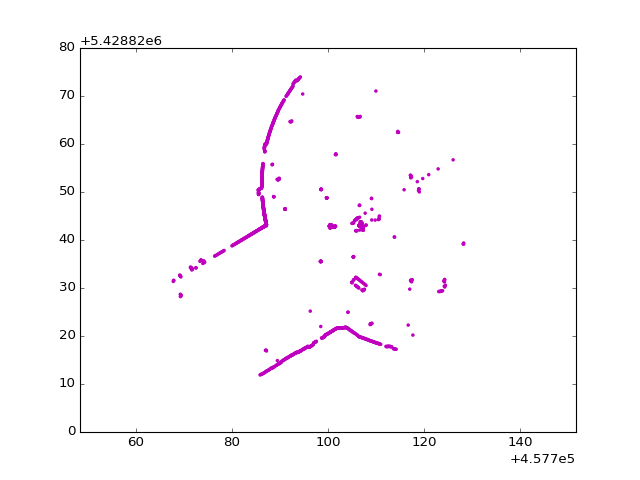

In [3]:
# rotate pointcloud
R = np.matrix([[np.cos(yaw),-np.sin(yaw)], [np.sin(yaw),np.cos(yaw)]])
pointcloud = pointcloud * np.transpose(R)

# translate pointcloud
pointcloud = pointcloud + np.matrix([xPos,yPos])

# show transformed pointcloud
plt.figure(1)
plt.axis('equal')
plt.scatter([pointcloud[:,0]],[pointcloud[:,1]],c='m',s=10,edgecolors='none')

### 3. Integration der Punktwolke in die Karte

Jeder der Zellen der Karte ist eine Wahrscheinlichkeit zugeordnet, mit der die Zellen belegt sind. Für die folgende Integration der Punktwolke in die Karte ist es sinnvoll die Wahrscheinlichkeit als logarithmiertes Quotenverhältnis (engl. Log odds) anzugeben:

<img src="LogOdd1.png" alt="Log odds" style="width: 175px;"/>

Mit dieser Notation ergeben sich für die oben genannten charakteristischen Wahrscheinlichkeiten folgende Werte:

<img src="LogOdd2.png" alt="Belegung Karte Log odds" style="width: 400px;"/>

Da die Umgebung am Anfang komplett unbekannt ist, wird die Karte mit 0 initialisiert. Die Zellgröße beträgt beispielsweise 0.1x0.1m.

In [4]:
# resolution of the grid
resolution = 0.1

# create grid 
grid = np.zeros((int(100.0/resolution),int(100.0/resolution)),order='C')

# offset of measurement in grid (x,y)
offset = np.array([xPos+50.0, yPos+50.0])

Wenn eine Messung integriert wird, wird die Wahrscheinlichkeit angepasst. In der Log-Odds Notation kann das sehr effizient über einfache Addition (erhöhen der Wahrscheinlichkeit, dass eine Zelle belegt ist) oder Subtraktion (verringern der Wahrscheinlichkeit) eines konstanten Wertes erfolgen.

In [5]:
l_occupied = 0.85
l_free = -0.4

Je höher der Wert eine Zelle ist, desto sicherer ist die Information, dass die Zelle belegt ist. Um Messunsicherheiten und Umgebungsveränderungen korrigieren zu können werden die Werte nach oben und unten begrenzt (engl. clamping).

In [6]:
l_max = 3.5
l_min = -2.0

Nun muss bestimmt werden, welche Zellen anhand der Punktwolke als *frei* und welche als *belegt* bestimmt werden können.

Die belegten Zellen zu bestimmen ist einfach: Jeder Punkt der Punktwolke repräsentiert eine Reflektion des Laserstrahls an einem Objekt. Damit ist die Zelle, in die dieser Punkt fällt belegt.

<img src="fig/sensormodell.png" alt="Inverses Sensormodell" style="width: 300px;"/>

Alle Zellen, die zwischen dem Sensor und den belegten Zellen liegen sind frei. Um diese Zellen zu besteimmen wird der ursprünglich für die Darstellung von Geraden in der Computergrafik entwickelte Algorithmus von Bresenham genutzt. Die Bestimmung der Zellen erfolgt effektiv da nahezu nur Additionen genutzt werden.

<img src="fig/bresenham.png" alt="Bresenham" style="width: 300px;"/>

Das verwendete Verfahren ist eine zweidimensionale Variante [dieser](https://gist.github.com/salmonmoose/2760072) Implementierung. Bei Übergabe von Start- und Endpunkt eines Strahls werden alle Zellen zurückgegeben, die nötig sind um diesen Strahl darzustellen.

In [7]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

# import bresenham algorithm
from lib import bresenham

Nun kann jeder Punkt der Punktwolke in die Messung integriert werden:

<IPython.core.display.Javascript object>


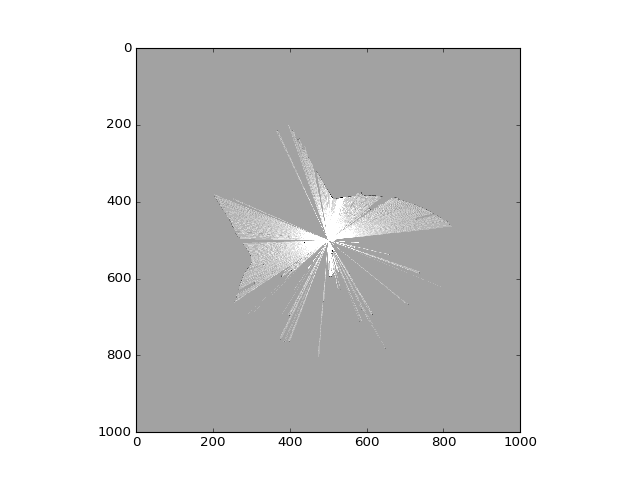

In [8]:
for ii in range(pointcloud.shape[0]):
    # round points to cells
    xi = int( (pointcloud[ii,0]-offset[0]) / resolution ) 
    yi = int( (pointcloud[ii,1]-offset[1]) / resolution )
    
    # set beam endpoint-cells as occupied 
    grid[xi,yi] += l_occupied
    
    # value > threshold? -> clamping 
    if grid[xi,yi] > l_max:
        grid[xi,yi] = l_max
    
    # calculate cells between sensor and endpoint as free with bresenham
    startPos = np.array([[int((xPos-offset[0])/resolution),int((yPos-offset[1])/resolution)]])
    endPos = np.array([[xi,yi]])
    bresenhamPath = bresenham.bresenham2D(startPos, endPos)
    
    # set free cells as free
    for jj in range(bresenhamPath.shape[0]):
        path_x = int(bresenhamPath[jj,0])
        path_y = int(bresenhamPath[jj,1])
        
        grid[path_x, path_y] += l_free
        
        # value < threshold? -> clamping
        if grid[path_x, path_y] < l_min:
            grid[path_x, path_y] = l_min

plt.figure(3)            
plt.imshow(grid[:,:], interpolation ='none', cmap = 'binary')

Weitere Punktwolken werden analog zu der Karte hinzugefügt. Diese Funktion wird für den SLAM Algorithmus in eine Funktion ausgelagert. Eine 3D Implementierung von Mapping With Known Poses gibt es [hier](https://github.com/balzer82/3D-OccupancyGrid-Python).

In [9]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## Teil II: Lokalisierung in einer bestehenden Karte mittels Partikelfilter

### Ablauf 

Das zweite Teilproblem des SLAM-Prozesses ist die Lokalisierung anhand einer Punktwolke in einer bestehenden Karte. Im SLAM-Prozess wird anhand eines Bewegungsmodells des Fahrzeugs eine erste Schätzung für die Position vorgenommen. Aufgabe der Lokalisierung in einer bestehenden Karte ist es, diese Schätzung anhander der neuen, gefilterten Punktwolke zu verbessern.

Die Position des Fahrzeugs wird vollständig mit zwei Koordinaten und einem Winkel beschrieben. **Es wird bestimmt, wie die Punktwolke verschoben und gedreht werden muss, damit sie bestmöglichst zu der Karte passt.** Dafür werden Partikel, die jeweils eine Lösung enthalten zufällig um die erwartete Position verteilt. 

Für jede dieser Lösungen mit einer Gütefunktion bewertet, wie gut die gefilterte Punktwolke zu der bis hierhin erstellte Karte passt. Das Partikel mit dem höchsten Wert der Gütefunktion stellt die beste Lösung dar.

<img src="fig/Ablauf_Partikel.png" alt="Ablauf Lokalisierung in einer bestehenden Karte" style="width: 400px;"/>

Um die Schätzung zu verbessern können ein oder mehrere der besten Partikel ausgewählt werden und an der Stelle dieser Lösungen neue Partikel verteilt werden. Diesmal wird der Suchradius, und damit das Gebiet, in dem die neuen Partikel erzeugt werden deutlich verkleinert.

Dadurch wird die Schätzung genauer. Wie oft diese Schritte durchgeführt werden hängt von der zur Verfügung stehenden Rechenzeit ab.

### 0. Laden der vorhandenen Karte

Um die Funktionsweise des Partikelfilters zu demonstrieren wird eine vorhandene Karte sowie die wie im Mapping gefilterte Punktwolke geladen. Die Punktwolke ist genau die, die als nächstes in die Karte integriert werden soll. Die Information aus dieser Punktwolke ist also noch nicht in die Karte integriert.

<IPython.core.display.Javascript object>


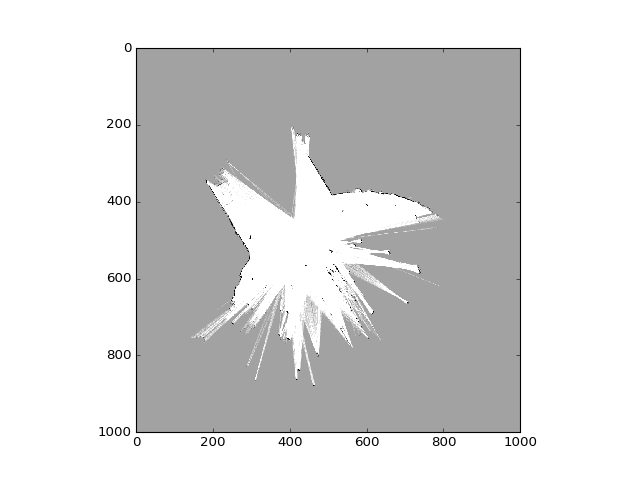

<IPython.core.display.Javascript object>


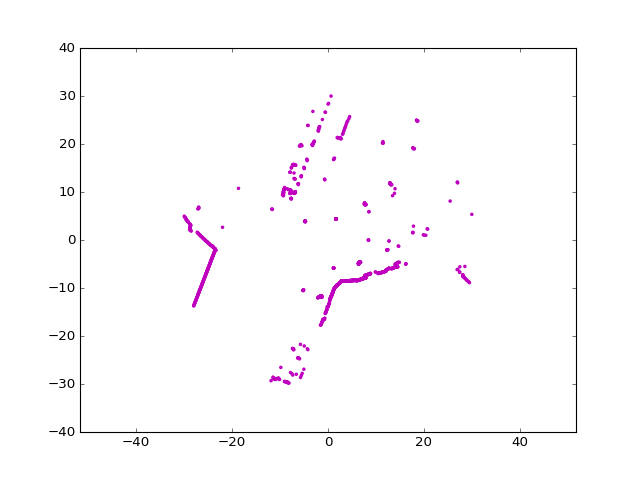

In [10]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

# load existing grid and filtered pointcloud
grid = np.loadtxt('data/grid_42.txt')
pointcloud = np.load('data/pointcloud_filtered_43.npy')

# show pointcloud and grid
plt.figure(0)
plt.imshow(grid[:,:], interpolation ='none', cmap = 'binary')
plt.figure(1)
plt.axis('equal')
plt.scatter(pointcloud[:,0],pointcloud[:,1],c='m',s=10,edgecolors='none')

### 1. Erzeugung Partikel um die geschätzte Position

Es soll die 43. Punktwolke in die Karte integriert werden. Eine erste Schätzung für die Position ist die Lage der 42. Punktwolke:

In [11]:
firstEstimate_x = 457805.156
firstEstimate_y = 5428851.291
firstEstimate_yaw = -0.697

Außerdem werden wie schon beim mapping die Auflösung sowie Verschiebung der Karte benötigt:

In [12]:
# resolution of the grid
resolution = 0.1

# offset of measurement in grid (x,y)
offset = np.array([[-50.0, -50.0]])
offsetStartPos = np.array([457797.930, 5428862.694])

Die Lösungen werden als Partikel als spezieller Datentyp in einer Liste gespeichert:

In [13]:
class Particle(object):
    def __init__(self, x, y, yaw, weight):
        self.x = x
        self.y = y
        self.yaw = yaw
        self.weight = weight
        
particles = []

Jetzt muss entschieden werden, wie weit um die letzte Position die neue Position erwartet wird. Entsprechend werden die Standardabweichungen für den Winkel und die Position gesetzt. Außerdem wird die Partikelanzahl festgelegt, dafür muss zwischen Genauigkeit und Rechenzeit abgewogen werden. 

In [14]:
# standard deviation of position and yaw
stddPos = 1.0
stddYaw = 0.02

# number of particels
nrParticle = 500

Die gewünscht Anzahl an Partikeln wird um die zunächste geschätzte Position verteilt:

In [15]:
for _ in range(0,nrParticle):
    x = np.random.normal(firstEstimate_x-offsetStartPos[0],stddPos)
    y = np.random.normal(firstEstimate_y-offsetStartPos[1],stddPos)
    yaw = np.random.normal(firstEstimate_yaw,stddYaw)

    # create particle and append ist to list
    p = Particle(x,y,yaw,1)
    particles.append(p)

### 2. Bewertung der Lösungen

Um die Güte der Lösungen zu bewerten, muss zunächst die Punktwolke anhand der jeweiligen Lösung wie beim Mapping an die entsprechende Position transformiert werden. Für jeden Punkt der Beobachtung wird die dazugehörige Zelle des Grids bestimmt. Die Summe der Log-Odds dieser Zellen beschreibt die Güte der Lösung. Je höher die Summe ist, desto besser ist die gefundene Position.

In [16]:
def scan2mapDistance(grid,pcl,offset,resolution):
    distance = 0;
    for i in range(pcl.shape[0]):
        # round points to cells
        xi = int ( (pcl[i,0]-offset[0,0]) / resolution )
        yi = int ( (pcl[i,1]-offset[0,1]) / resolution ) 
        distance += grid[xi,yi]
    return distance

Mit der Gütefunktion können alle Lösungen bewertet werden:

In [17]:
# weight all particles
for p in particles:
    # rotate pointcloud
    R = np.matrix([[np.cos(p.yaw),-np.sin(p.yaw)], [np.sin(p.yaw),np.cos(p.yaw)]])
    pointcloudTransformed = pointcloud * np.transpose(R)
    
    # translate pointcloud
    pointcloudTransformed = pointcloudTransformed + np.matrix([p.x,p.y])
    
    # weight particle
    p.weight = scan2mapDistance(grid,pointcloudTransformed,offset,resolution)

## 3. Auswahl der besten Partikel

Die Partikel werden in absteigender Reihenfolge nach ihrerem Gewicht sortiert. So können zum Beispiel die besten zehn Partikel ausgewählt werden.

In [18]:
# sort particles
particles.sort(key = lambda Particle: Particle.weight,reverse=True)

# get ten best particles
bestParticles = particles[:10]

# get best particle
bestParticle = particles[0]

Die Punktwolke anhand der besten Lösung transformiert und passt sehr gut zu der Karte. Zusätzlich sind alle Partikel sowie die besten Partikel dargestellt. Die besten Partikel streuen, sind aber an etwa der gleichen Position.

<IPython.core.display.Javascript object>


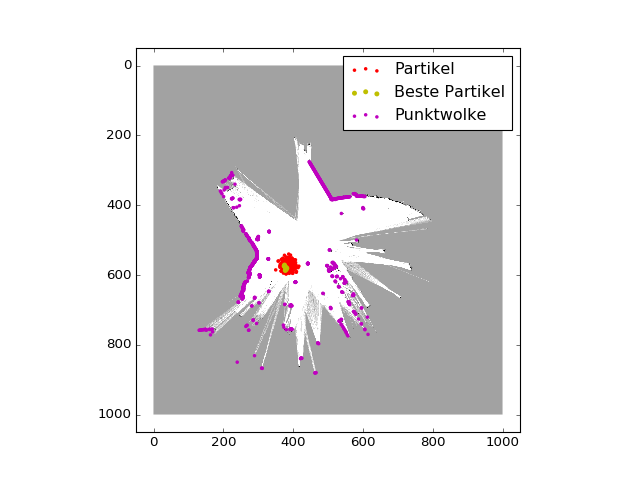

In [19]:
# plot grid
plt.figure(2)
plt.imshow(grid[:,:], interpolation ='none', cmap = 'binary')

# get position of all particles
xy = [[p.x,p.y] for p in particles]
x,y = zip(*xy)

# plot all particles
plt.scatter((y-offset[0,1])/resolution,(x-offset[0,0])/resolution,
             c='r',s=10,edgecolors='none',label='Partikel')

# plot 10 best particles
plt.scatter((y[0:10]-offset[0,1])/resolution,(x[0:10]-offset[0,0])/resolution,
             c='y',s=20,edgecolors='none',label='Beste Partikel')

# plot best estimate pointcloud
R = np.matrix([[np.cos(bestParticle.yaw),-np.sin(bestParticle.yaw)],
               [np.sin(bestParticle.yaw),np.cos(bestParticle.yaw)]])
pointcloudTransformed = pointcloud * np.transpose(R)
pointcloudTransformed = pointcloudTransformed + np.matrix([bestParticle.x,bestParticle.y])
plt.scatter([(pointcloudTransformed[:,1]-offset[0,0])/resolution],
            [(pointcloudTransformed[:,0]-offset[0,1])/resolution],
             c='m',s=10,edgecolors='none',label='Punktwolke')
plt.legend()

## 4. Resampling

Um die Schätzung weiter zu verbessern werden in der Umgebung der besten Lösungen neue Partikel verteilt. Diesemal ist der Suchradius jedoch deutlich geringer, sodass die Schätzung genauer wird.


In [20]:
# standard deviation of position and yaw for resampling
stddPosResample = stddPos/5.0
stddYawResample = stddYaw/5.0

# number of particels
nrParticleResample = 50

Verteilung der Partikel um die besten bisherigen Lösungen:

In [21]:
# delete old particles
particles.clear()

# create 50 particles for each of the best 10 particles
for bp in bestParticles:
    for _ in range(0,nrParticleResample):
        x = np.random.normal(bp.x,stddPosResample)
        y = np.random.normal(bp.y,stddPosResample)
        yaw = np.random.normal(bp.yaw,stddYawResample)

        # create particle and append ist to list
        p = Particle(x,y,yaw,1)
        particles.append(p)

Auch diese Lösungen werden bewertet und sortiert:

In [22]:
# weight all particles
for p in particles:
    # rotate pointcloud
    R = np.matrix([[np.cos(p.yaw),-np.sin(p.yaw)], [np.sin(p.yaw),np.cos(p.yaw)]])
    pointcloudTransformed = pointcloud * np.transpose(R)
    
    # translate pointcloud
    pointcloudTransformed = pointcloudTransformed + np.matrix([p.x,p.y])
    
    # weight particle
    p.weight = scan2mapDistance(grid,pointcloudTransformed,offset,resolution)
    
# sort particles
particles.sort(key = lambda Particle: Particle.weight,reverse=True)

## 5. Auswahl des besten Partikels

Der Schritt zuvor kann beliebig oft wiederholt werden. Am Ende wird die beste Lösung ausgewählt. Es ist gut erkennbar, dass die neuen Partikel durch die geringere Standardabweichung weniger streuen als die ersten.

<IPython.core.display.Javascript object>


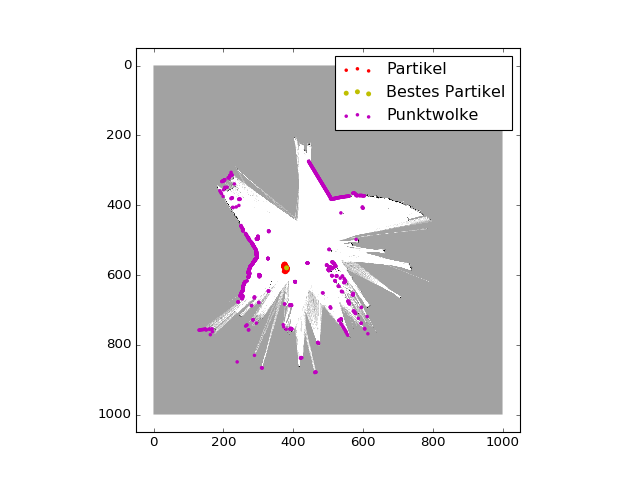

In [23]:
# get best particle
bestParticle = particles[0]

# plot grid
plt.figure(3)
plt.imshow(grid[:,:], interpolation ='none', cmap = 'binary')

# get position of all particles
xy = [[p.x,p.y] for p in particles]
x,y = zip(*xy)

# plot all particles
plt.scatter((y-offset[0,1])/resolution,(x-offset[0,0])/resolution,
             c='r',s=10,edgecolors='none',label='Partikel')

# plot best particle
plt.scatter((y[0]-offset[0,1])/resolution,(x[0]-offset[0,0])/resolution,
             c='y',s=20,edgecolors='none',label='Bestes Partikel')

# plot best estimate pointcloud
R = np.matrix([[np.cos(bestParticle.yaw),-np.sin(bestParticle.yaw)],
               [np.sin(bestParticle.yaw),np.cos(bestParticle.yaw)]])
pointcloudTransformed = pointcloud * np.transpose(R)
pointcloudTransformed = pointcloudTransformed + np.matrix([bestParticle.x,bestParticle.y])
plt.scatter([(pointcloudTransformed[:,1]-offset[0,0])/resolution],
            [(pointcloudTransformed[:,0]-offset[0,1])/resolution],
             c='m',s=10,edgecolors='none',label='Punktwolke')
plt.legend()

In [24]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## Teil III: Zusammengesetzter SLAM Algorithmus

Als Bindeglied zwischen Mapping with Known Poses und der Lokalisierung in einer bestehenden Karte fehlt die erste Schätzung für die Position, um die bei der Lokalisierung die Partikel verteilt werden.

Die ersten beiden Teile sind für eine bessere übersicht in Funktionen ausgelagert worden. Um die Laufzeit zu optimieren werden sie teilweise mit [Numba](https://numba.pydata.org/) zur Laufzeit kompiliert.

In [25]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

# import some pointcloud filter functions
from lib import filterPCL    
    
# import mapping algorithm
from lib import mapping

# import particle filter
from lib import posEstimation

### Bewegungsmodell

Die Lokalisierung in einer bestehenden Karte benötigt eine erste Schätzung der Position des Roboters. Eine sehr grobe Näherung wäre die letzte bekannte Position, für eine Verringerung der Laufzeit bei gleichzeitig besserer Lösung muss diese Näherung verbessert werden. Ab der dritten zu integrierenden Beobachtung kenn man die beiden vorherigen Positionen des Roboters. Wenn gleichförmige Bewegung sowohl in der Translation als auch in der Rotation des Roboters angenommen wird, kann über die vorherige Veränderung der Position die erste Schätzung erstellt werden.

Diese Schätzung dient als Grundlage für die zuvor erläuterte Lokalisierung in einer bestehenden Karte. Vorteil dieses Bewegungsmodells ist, dass es unabhängig von der Roboterplattform ist und gut mit geringem Aufwand parametrisiert werden kann.

### Ablauf

Mit dem Bewegungsmodell kann das Mapping With Known Poses und die Lokalisierung in einer bestehenden Karte zum SLAM Prozess zusammengesetzt werden: 

<img src="fig/Ablauf_SLAM.png" alt="Ablauf SLAM" style="width: 400px;"/>

Zum Startzeitpunkt ist die Umgebung komplett unbekannt, die Startposition wird als bekannt vorausgesetzt beziehungsweise ist beliebig. An dieser Position wird die erste Beobachtung integriert. Dabei steigt für jeden Punkt, der in einer Zelle liegt, die Wahrscheinlichkeit

Die Karte wird nun genutzt, um die nächste Punktwolke relativ zur Karte zu orientieren. Da noch keine Informationen über die Bewegung des Roboters vorliegen wird in allen Richtungen mit einem verhältnismäßig großen Radius getestet, wo die zweite Punktwolke am besten mit der Karte übereinstimmt. Dafür werden Lösungen zufällig im Suchraum der drei Parameter der Position verteilt und die Lösungen mit der Gütefunktion bewertet. Nach mehreren Iterationen des Partikelfilters wird die beste Lösung ausgewählt und die Beobachtung in die Karte integriert.

Da nun zwei Positionen bekannt sind, kann die Differenz und damit die Bewegung des Roboters im letzten Zeitschritt bestimmt werden. Mit dem allgemein gehaltene Bewegungsmodell erfolgt unter Annahme gleichförmiger Bewegung eine erste Schätzung der folgenden Position. Diese Schätzung führt dazu, dass der Suchraum für den Partikelﬁlter deutlich eingegrenzt wird. Der erneut mehrstuﬁg angewendete Partikelﬁlter liefert so in kürzerer Zeit eine gute Lokalisierung. 

Die folgenden Beobachtungen werden auf gleiche Art in der Karte verortet und anschließend in sie integriert.

### 0. Initialisierung

Als Testdaten werden die eingangs beschriebenen Daten der [KITTI Vision Benchmark Suite](http://www.cvlibs.net/) verwendet, die müssen zuvor exportiert und lokal gespeichert werden.

In [26]:
path = 'E:/KITTI_Daten/2011_09_30_drive_0027_export/'

Laden der Startposition, Angabe der Parameter, der als Vergleich dienenden wahren Trajektorie und Initialisierung des Grids:

In [27]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import math
import time

"""
Load data
"""
# load start pose
startPose = np.loadtxt(path+'firstPose.txt',delimiter=',')
# load ground truth trajectory
groundTruth = np.asmatrix(np.loadtxt(path+'groundTruth.txt',delimiter=','))
nrOfScans = np.shape(groundTruth)[0]-1

"""
Parameter
"""
# parameter pointlcoud filter
zCutMin = -0.05
zCutMax = 0.05
# parameter mapping from octomap paper
l_occupied = 0.85
l_free = -0.4
l_min = -2.0
l_max = 3.5
# parameter particle Filter
stddPos = 0.1
stddYaw = 0.20

"""
Create empty GRID [m] and initialize it with 0, this Log-Odd 
value is maximum uncertainty (P = 0.5)
Use the ground truth trajectory to calculate width and length of the grid
"""
additionalGridSize = 200.0
length = groundTruth[:,0].max()-groundTruth[:,0].min()+additionalGridSize
width = groundTruth[:,1].max()-groundTruth[:,1].min()+additionalGridSize
resolution = 0.25
grid = np.zeros((int(length/resolution),int(width/resolution)),order='C')

"""
Calculate best startposition in grid
"""
offset = np.array([math.fabs(groundTruth[0,0]-groundTruth[:,0].min()+additionalGridSize/2.0),
                   math.fabs(groundTruth[0,1]-groundTruth[:,1].min()+additionalGridSize/2.0),
                   0.0])

print('Length: '+str(length))
print('Width: '+str(width))

"""
Other variables
"""
# save estimated pose (x y yaw) in this list
trajectory = []
# save the estimated pose here (mouvement model)
estimatePose = np.matrix([startPose[0],startPose[1],startPose[2]])

Length: 425.343
Width: 371.525


### 1. Integration der ersten Punktwolke an initialer Position

Die Position des Fahrzeugs während der Aufnahme der ersten Punktwolke ist bekannt, daher kann die Integration wie beim Mapping With Known Poses erfolgen.

In [28]:
# load pointcloud
pointcloud = np.load(path+'pointcloudNP_'+str(0)+'.npy')
# filter poinctloud and project it to xy plane
pointcloud = filterPCL.filterZ(pointcloud,zCutMin,zCutMax)
pointcloud = np.delete(pointcloud,2,1)
# transform pointcloud to initial position
R = np.matrix([[np.cos(startPose[2]),-np.sin(startPose[2])],
               [np.sin(startPose[2]),np.cos(startPose[2])]])
pointcloud = pointcloud * np.transpose(R)
pointcloud = pointcloud + np.matrix([startPose[0],
                                     startPose[1]])

# add measurement to grid
mapping.addMeasurement(grid,pointcloud[:,0],pointcloud[:,1],
                       np.matrix([startPose[0],startPose[1],startPose[2]]),
                       startPose-offset,resolution,
                       l_occupied,l_free,l_min,l_max)

# add position to trajectory
trajectory.append(startPose)


### 2. Integration der zweiten Punktwolke

Nach nur einer integrierten Punktwolke ist keine Informationen über die Bewegung des Fahrzeugs vorhanden. Daher wird in einem großen Umkreis nach der richtigen Position gesucht. Diese Suche dauert durch die große Partikelanzahl länger, als Teil der Initialisierung ist das vertretbar.

In [29]:
# load pointcloud
pointcloud = np.load(path+'pointcloudNP_'+str(1)+'.npy')
# filter poinctloud and project it to xy plane
pointcloud = filterPCL.filterZ(pointcloud,zCutMin,zCutMax)
pointcloud = np.delete(pointcloud,2,1)

# estimate position
estimatePose = posEstimation.fitScan2Map(grid,pointcloud,25000,10,2500,
               estimatePose,stddPos*10,stddYaw*10,
               startPose,offset,resolution)

# transform pointcloud to estimated position
R = np.matrix([[np.cos(estimatePose[0,2]),-np.sin(estimatePose[0,2])],
               [np.sin(estimatePose[0,2]),np.cos(estimatePose[0,2])]])
pointcloud = pointcloud * np.transpose(R)
pointcloud = pointcloud + np.matrix([estimatePose[0,0],
                                     estimatePose[0,1]])

# add measurement to grid
mapping.addMeasurement(grid,pointcloud[:,0],pointcloud[:,1],
                       np.matrix([estimatePose[0,0],estimatePose[0,1],estimatePose[0,2]]),
                       startPose-offset,resolution,
                       l_occupied,l_free,l_min,l_max)

# add position to trajectory
trajectory.append(estimatePose)

### 3. Integration der weiteren Punktwolken

Da nun zwei Positionen bekannt sind, kann das Bewegungsmodell angewendet werden: Es wird gleichförmige Bewegung angenommen, also wird die Differenz der letzten beiden Positionen ausgerechnet und zu der letzten Position addiert. Die erste Schätzung für den Partikelfilter ist so deutlich besser als bei der Integration der zweiten Punktwolke.

In [30]:
# calculate difference of last to positions
deltaPose = trajectory[-1]-trajectory[-2]
# calculate first estimate for new position
estimatePose = trajectory[-1]+deltaPose

print('Difference of last two postitions:')
print('x='+str(deltaPose[0,0])+'m y='+str(deltaPose[0,1])+'m yaw='+str(deltaPose[0,2])+'rad')
print('First estimate for new position:')
print('x='+str(estimatePose[0,0])+'m y='+str(estimatePose[0,1])+'m yaw='+str(estimatePose[0,2])+'rad')

Difference of last two postitions:
x=0.056187174865m y=-0.0726430555806m yaw=0.00413078983134rad
First estimate for new position:
x=455637.042374m y=5425990.93371m yaw=-0.548738420337rad


Mit dieser ersten Schätzung können alle weiteren Messungen in die Karte integriert werden:

In [31]:
t0 = time.time()
for ii in range(2,nrOfScans+1):
    # load pointcloud
    pointcloud = np.load(path+'pointcloudNP_'+str(ii)+'.npy')
    # filter poinctloud and project it to xy plane
    pointcloud = filterPCL.filterZ(pointcloud,zCutMin,zCutMax)
    pointcloud = np.delete(pointcloud,2,1)
    
    # calculate difference between last to positions
    deltaPose = trajectory[-1]-trajectory[-2]
    # calculate first estimate for new position
    estimatePose = trajectory[-1]+deltaPose
    
    # estimate position with two resamplings
    estimatePose = posEstimation.fitScan2Map2(grid,pointcloud,500,1,250,250,
               estimatePose,stddPos,stddYaw,
               startPose,offset,resolution)
    
    # transform pointcloud to estimated position
    R = np.matrix([[np.cos(estimatePose[0,2]),-np.sin(estimatePose[0,2])],
                   [np.sin(estimatePose[0,2]),np.cos(estimatePose[0,2])]])
    pointcloud = pointcloud * np.transpose(R)
    pointcloud = pointcloud + np.matrix([estimatePose[0,0],
                                         estimatePose[0,1]])

    # add measurement to grid
    mapping.addMeasurement(grid,pointcloud[:,0],pointcloud[:,1],
                           np.matrix([estimatePose[0,0],estimatePose[0,1],estimatePose[0,2]]),
                           startPose-offset,resolution,
                           l_occupied,l_free,l_min,l_max)

    # add position to trajectory
    trajectory.append(estimatePose)

    # print update
    if ii%10 == 0:
        print('Measurement '+str(ii)+' of '+str(nrOfScans)+' processed: '+str(time.time()-t0)+'s')

print('Finished, '+str(ii)+' measurements processed. Timer per measurement: '+str((time.time()-t0)/ii)+'s')

Measurement 10 of 1105 processed: 2.576207160949707s
Measurement 20 of 1105 processed: 5.194946527481079s
Measurement 30 of 1105 processed: 7.752157211303711s
Measurement 40 of 1105 processed: 10.853665351867676s
Measurement 50 of 1105 processed: 15.920048475265503s
Measurement 60 of 1105 processed: 20.42853832244873s
Measurement 70 of 1105 processed: 23.73824977874756s
Measurement 80 of 1105 processed: 27.152014017105103s
Measurement 90 of 1105 processed: 30.637826204299927s
Measurement 100 of 1105 processed: 33.85546064376831s
Measurement 110 of 1105 processed: 38.11578845977783s
Measurement 120 of 1105 processed: 42.51420497894287s
Measurement 130 of 1105 processed: 45.73684287071228s
Measurement 140 of 1105 processed: 48.72582793235779s
Measurement 150 of 1105 processed: 51.63630676269531s
Measurement 160 of 1105 processed: 55.06708526611328s
Measurement 170 of 1105 processed: 59.237348794937134s
Measurement 180 of 1105 processed: 62.94831371307373s
Measurement 190 of 1105 processe

Der SLAM Prozess ist beendet. Ausgabe des Ergebnisses:

<IPython.core.display.Javascript object>


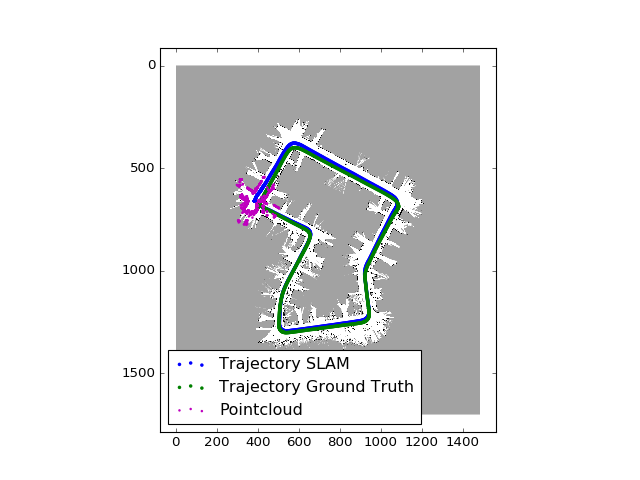

In [32]:
# show grid
plt.figure(0)
plt.imshow(grid[:,:], interpolation ='none', cmap = 'binary')
# plot trajectory
trajectory = np.vstack(trajectory)
plt.scatter(([trajectory[:,1]]-startPose[1]+offset[1])/resolution,
            ([trajectory[:,0]]-startPose[0]+offset[0])/resolution,
            c='b',s=10,edgecolors='none', label = 'Trajectory SLAM')


# plot ground truth trajectory
plt.scatter(([groundTruth[:,1]]-startPose[1]+offset[1])/resolution,
            ([groundTruth[:,0]]-startPose[0]+offset[0])/resolution,
            c='g',s=10,edgecolors='none', label = 'Trajectory Ground Truth')

# plot last pointcloud
plt.scatter(([pointcloud[:,1]]-startPose[1]+offset[1])/resolution,
            ([pointcloud[:,0]]-startPose[0]+offset[0])/resolution,
            c='m',s=5,edgecolors='none', label = 'Pointcloud')            
        
# plot legend
plt.legend(loc='lower left')